# Results Optiwise inverse dynamics

In [773]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [774]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper
from phd.visualization.styles import styles
from vessel_manoeuvring_models.KF_multiple_sensors import interpolate_and_insert_all
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker
from vessel_manoeuvring_models import IMO_evaluation
from sklearn.metrics import mean_squared_error, r2_score

In [775]:
ship_name = "optiwise"

In [985]:
#%reload_kedro

#%reload_kedro
loaders = {f"polynomial rudder {name}":loader for name,loader in catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL").items()}
#loader={}
loaders["semiempirical rudder"] = catalog.load(f"{ship_name}.models_VCT_MDL")['semiempirical_covered_inertia']
loaders["measured rudder"] = catalog.load(f"{ship_name}.models_measured_rudder_force")['semiempirical_covered_inertia']
loaders["MMG_rudder"] = catalog.load(f"{ship_name}.models_VCT_MMG_rudder_MDL")["MMG"]
loaders.pop('polynomial rudder complex')  # for now...

ship_data = catalog.load(f"{ship_name}.ship_data")

[11/28/24 10:26:08] INFO     Loading data from 'optiwise.models_VCT_polynomial_rudder_MDL'      ]8;id=326315;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=204032;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.models_VCT_MDL'                        ]8;id=193280;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=352642;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.models_measured_rudder_force'          ]8;id=618149;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=550551;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.models_VCT_MMG_rudder_MDL'             ]8;id=809001;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=151103;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.ship_data' (YAMLDataSet)...            ]8;id=421135;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=373033;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [986]:
models = {name:loader() for name,loader in loaders.items()}
model = models["semiempirical rudder"]

In [987]:
meta_datas_all = catalog.load(f"{ship_name}.test_meta_data")

meta_datas_all = meta_datas_all.groupby('test_type').get_group('zigzag')
mask = meta_datas_all['ship_speed'] > 0.9
meta_datas_all = meta_datas_all.loc[mask].copy()

[11/28/24 10:26:15] INFO     Loading data from 'optiwise.test_meta_data' (CSVDataSet)...        ]8;id=492131;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=31863;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [988]:
meta_datas = meta_datas_all.loc[[23590, 23591, 23594, 23596]].copy()

## Compare forces

In [989]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
#model = catalog.load(f"{ship_name}.models_VCT")['semiempirical_covered_inertia']()
df_VCT_hydro = subtract_centripetal_and_Coriolis(df_VCT=df_VCT, model=model)

                    INFO     Loading data from 'optiwise.df_VCT_scaled' (CSVDataSet)...         ]8;id=225003;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=429222;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [990]:
for name, model_ in models.items():
    #model_.parameters['Yvdot'] = -0.015473
    model_.parameters['Nrdot'] = 1.0*-0.0007267535092566891

In [991]:
round = {
    'u':4,
    'v':4,
    'r':3,
    'delta':3,
}

keys_rounded = [f"{key}_round" for key in round.keys()]

for key,decimals in round.items():
    df_VCT_hydro[f"{key}_round"] = np.round(df_VCT_hydro[key], decimals=decimals)

_=[]
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    for key,decimals in round.items():
        df_EKF_smooth[f"{key}_round"] = np.round(df_EKF_smooth[key], decimals=decimals)

    df_EKF_smooth['time'] = df_EKF_smooth.index

    mask = df_EKF_smooth.duplicated(keys_rounded)
    df_ = df_EKF_smooth.loc[~mask]

    points = pd.merge(left=df_, right=df_VCT_hydro, how='inner', left_on=keys_rounded, right_on=keys_rounded, suffixes=('','_vct'))
    points.set_index('time', inplace=True)
    assert points.index.is_unique
    points['id'] = id
    #points_all[id]=points
    _.append(points)

points_all = pd.concat(_)
points_all['id'] = points_all['id'].astype(int)

[11/28/24 10:26:16] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=241068;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=571640;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=464696;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=686199;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=505323;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=1775;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=556838;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=246613;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [992]:
styles['polynomial rudder simple'] = styles['polynomial rudder']
styles['polynomial rudder complex'] = {'style':'m-','label':'complex'}

In [993]:
#models["MMG_rudder"].parameters['l_R']=1*-2.389705882205995

In [994]:
#models['MMG_rudder'].parameters['l_R']=1*-4.3047794115

In [995]:
model_ = models["semiempirical rudder"]

In [996]:
model_.system_connections


{
    'mmg_wake_system': {w_f: ['rudder']},
    'rudder': {Y_R: ['rudder_hull_interaction'], N_R: ['rudder_hull_interaction']}
}

In [997]:
system = model_.subsystems['mmg_wake_system']
system.equations


{
    'beta': Eq(beta, atan2(-v, u)),
    'beta_p': Eq(beta_p, beta - r*x_p),
    'C_2': Eq(C_2, Piecewise((C_2_beta_p_pos, beta_p > 0), (C_2_beta_p_neg, True))),
    'w_f': Eq(w_f, (-C_2*w_p0 + C_2 + w_p0 + (C_2*w_p0 - C_2 + 1)*exp(C_1*Abs(beta_p)) - 1)*exp(-C_1*Abs(beta_p)))
}

In [998]:
eq_X_D = remove_functions(sp.Eq(
            X_D, sp.solve(model.X_eq.subs(model.X_D_eq.rhs, model.X_D_eq.lhs), X_D_)[0]
        ))

eq_Y_D = remove_functions(sp.Eq(
            Y_D, sp.solve(model.Y_eq.subs(model.Y_D_eq.rhs, model.Y_D_eq.lhs), Y_D_)[0]
        ))

eq_N_D = remove_functions(sp.Eq(
            N_D, sp.solve(model.N_eq.subs(model.N_D_eq.rhs, model.N_D_eq.lhs), N_D_)[0]
        ))

In [999]:
eq_Y_D

Eq(Y_D, -X_{\dot{u}}*r*u - Y_{\dot{r}}*\dot{r} - Y_{\dot{v}}*\dot{v} + \dot{r}*m*x_G + \dot{v}*m + m*r*u)

In [1000]:
eq_N_D

Eq(N_D, I_z*\dot{r} - N_{\dot{r}}*\dot{r} - N_{\dot{v}}*\dot{v} + X_{\dot{u}}*u*v - Y_{\dot{r}}*r*u - Y_{\dot{v}}*u*v + \dot{v}*m*x_G + m*r*u*x_G)

In [1001]:
models_ = pd.Series(models)
models_ = models_[["measured rudder"]].copy()


In [1002]:
#model_.parameters['C_2_beta_p_pos']=1.6
#model_.parameters['C_2_beta_p_neg']=1.1

In [1003]:
model_ = model.copy()

In [1004]:
#model_.parameters['Nrdot']=1.0*-0.0007267535092566891
#model_.parameters['Yvdot']=1.0*-0.015473
#model_.parameters['Xudot']=1.0*-0.001864
#model_.ship_parameters['m']=1.0*1008.7268469541564
#model_.set_ship_parameters(model_.ship_parameters)

[11/28/24 10:26:24] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=828200;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=975800;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=810429;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=826126;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/28/24 10:26:25] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=686939;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=58949;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=474810;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=127350;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

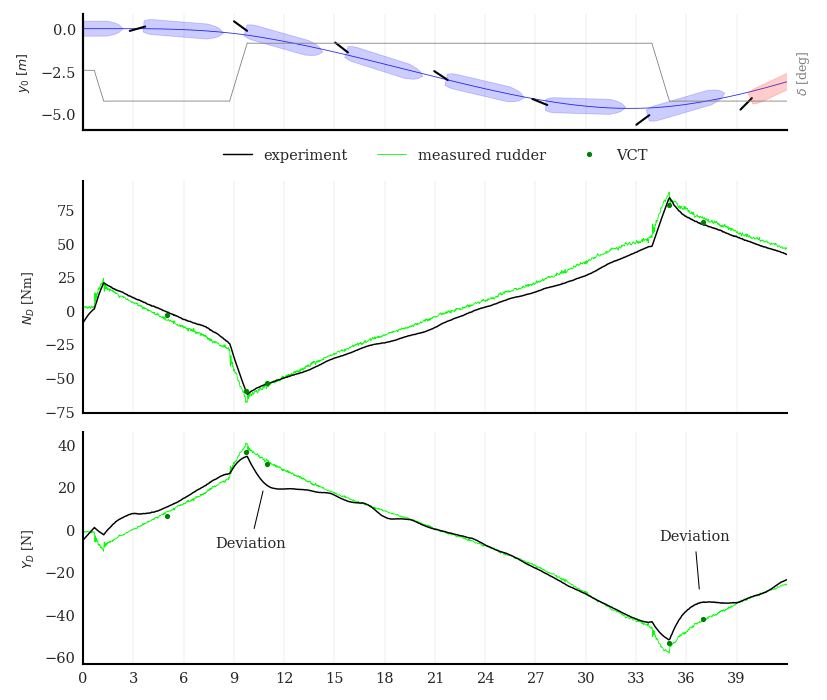

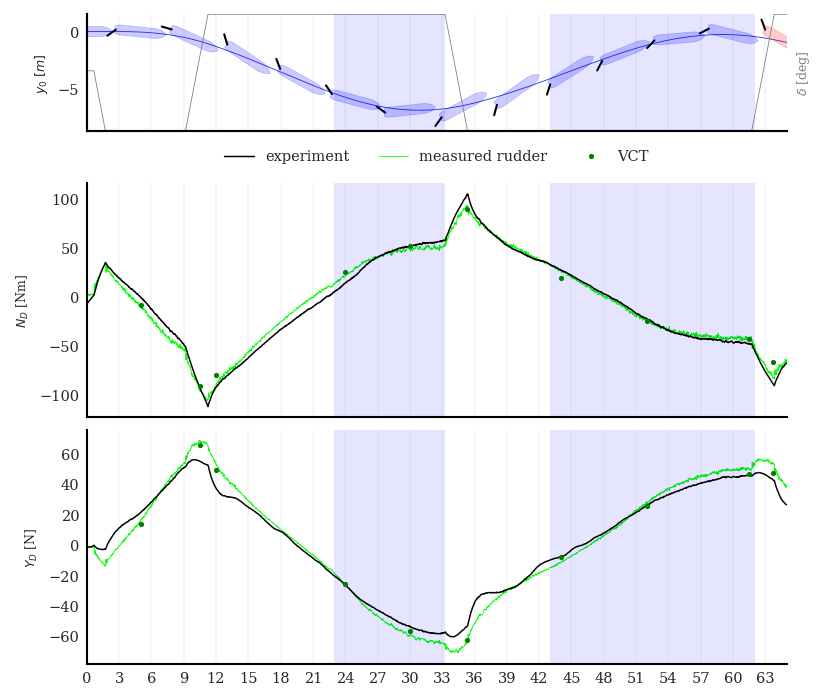

In [1005]:
t_maxs = {
    23590 : 42, 
    23594 : 65,
}

units_ = units.copy()
units_.pop('Y_R')

for id, meta_data in meta_datas.loc[[23590,23594]].iterrows():
    
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    #keys=['N_D','Y_D','alpha']
    keys=['N_D','Y_D',]
    fig = plot_compare_model_forces(model=model_, models=models_, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units_, symbols=symbols);
    
    

    
    #for ax in fig.axes[1:5]:
    #    ylims = ax.get_ylim()
    #    ylims = [min([ylims[0],-30]), max([ylims[1],30]),]
    #    ax.set_ylim(ylims)
    
    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    #fig.suptitle(name)


    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes[1:],keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='VCT', zorder=100)


    if id==23594:
        for i,ax in enumerate(fig.axes):

            if i==0:
                continue
            
            ylims = ax.get_ylim()
            ax.fill([43,43,62,62], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1, zorder=-100)

        for i,ax in enumerate(fig.axes):

            if i==0:
                continue
            
            ylims = ax.get_ylim()
            ax.fill([23,23,33.3,33.3], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1, zorder=-100)

    if id==23590:
        fig.axes[2].annotate("Deviation", xy=(10.8,20), xytext=(10,-10), 
                    size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='bottom')

        fig.axes[2].annotate("Deviation", xy=(36.8,-30), xytext=(36.5,0), 
                    size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='top')

        
    
    fig.axes[1].legend(loc='upper left', ncols=5)
    for ax in fig.axes[2:]:
        try:
            ax.get_legend().set_visible(False)
        except:
            pass


    for ax in fig.axes[0:-1]:
        ax.set_xlabel('')
    fig.axes[-1].set_xlabel('Time [s]')
    
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.50, 1.20), ncol=4)


    
    loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
    for ax in fig.axes:
        ax.xaxis.set_major_locator(loc)
        ax.grid(True, axis='x')
        ax.grid(False, axis='y')

    fig.set_size_inches(paper.figure_width,1.5*paper.figure_height)
    
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    #fig.suptitle(name)
        
    file_name = name.replace("/","_")
    #paper.save_fig(fig, f"{file_name}.svg")

In [1006]:
#for name, model_ in models.items():
#    model_.ship_parameters['m']=1.0*1008.7268469541564
#    model_.set_ship_parameters(model_.ship_parameters)

[11/28/24 10:26:27] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=701371;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=112855;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=850475;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=728138;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/28/24 10:26:28] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=727787;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=162927;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=98221;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=303407;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

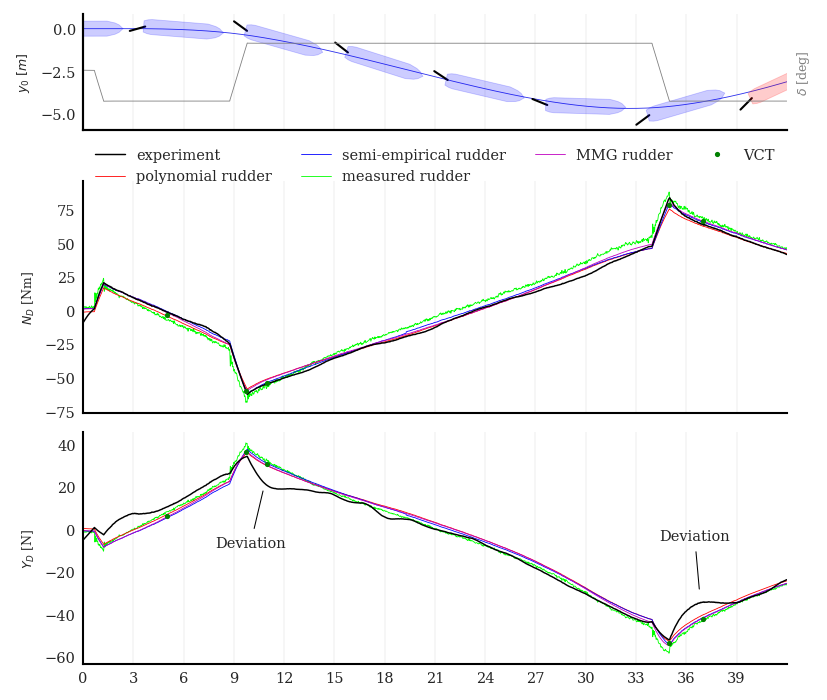

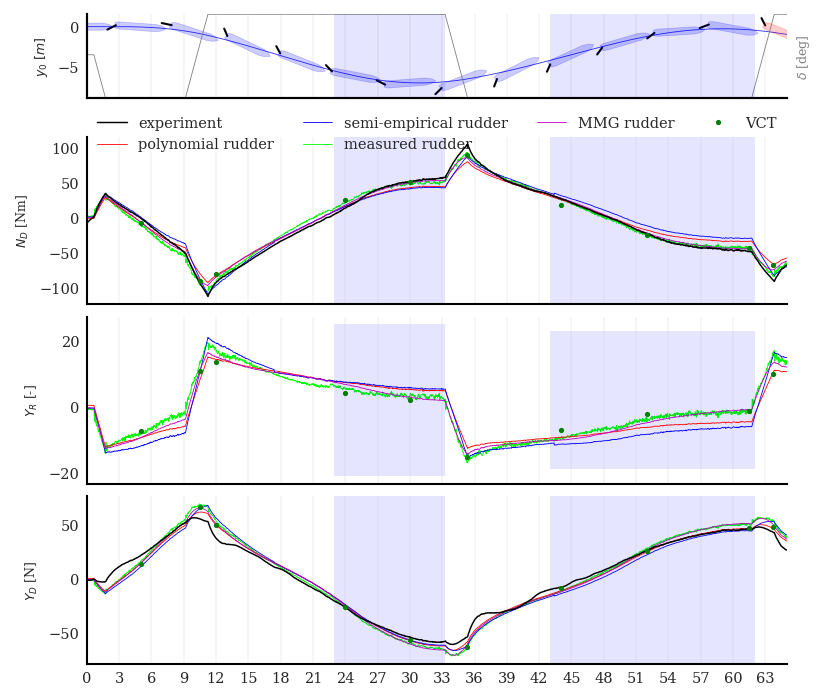

In [1007]:
t_maxs = {
    23590 : 42, 
    23594 : 65,
}

units_ = units.copy()
units_.pop('Y_R')

for id, meta_data in meta_datas.loc[[23590,23594]].iterrows():
    
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    #keys=['N_D','Y_D','alpha']
    if id==23590:
        keys=['N_D','Y_D',]
    else:
        keys=['N_D','Y_R','Y_D',]
    fig = plot_compare_model_forces(model=model, models=models, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units_, symbols=symbols);
    
    

    
    #for ax in fig.axes[1:5]:
    #    ylims = ax.get_ylim()
    #    ylims = [min([ylims[0],-30]), max([ylims[1],30]),]
    #    ax.set_ylim(ylims)
    
    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    #fig.suptitle(name)


    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes[1:],keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='VCT', zorder=100)


    if id==23594:
        for i,ax in enumerate(fig.axes):

            if i==0:
                continue
            
            ylims = ax.get_ylim()
            ax.fill([43,43,62,62], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1, zorder=-100)

        for i,ax in enumerate(fig.axes):

            if i==0:
                continue
            
            ylims = ax.get_ylim()
            ax.fill([23,23,33.3,33.3], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1, zorder=-100)

    if id==23590:
        fig.axes[2].annotate("Deviation", xy=(10.8,20), xytext=(10,-10), 
                    size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='bottom')

        fig.axes[2].annotate("Deviation", xy=(36.8,-30), xytext=(36.5,0), 
                    size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='top')

        
    
    fig.axes[1].legend(loc='upper left', ncols=5)
    for ax in fig.axes[2:]:
        try:
            ax.get_legend().set_visible(False)
        except:
            pass


    for ax in fig.axes[0:-1]:
        ax.set_xlabel('')
    fig.axes[-1].set_xlabel('Time [s]')
    
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.50, 1.20), ncol=4)


    
    loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
    for ax in fig.axes:
        ax.xaxis.set_major_locator(loc)
        ax.grid(True, axis='x')
        ax.grid(False, axis='y')

    fig.set_size_inches(paper.figure_width,1.5*paper.figure_height)
    
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    #fig.suptitle(name)
        
    file_name = name.replace("/","_")
    paper.save_fig(fig, f"{file_name}.svg")
    

In [1008]:
model_ = models['semiempirical rudder']

model_.parameters['kappa_v_neg']=1*0.5333330245455832
model_.parameters['kappa_v_pos']=0*0.5333330245455832

model_.parameters['kappa_r_neg']=0.6954713902464055
model_.parameters['kappa_r_pos']=3*0.6954713902464055



In [1009]:
model_ = models['MMG_rudder']

#model_.parameters['gamma_R_neg']=1.5*0.5
#model_.parameters['gamma_R_pos']=2*0.5
#model_.parameters['l_R']=0.7*-3.345588235088393




[11/28/24 10:26:31] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=387911;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=258508;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=913994;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=991123;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/28/24 10:26:32] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=899239;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=874876;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=705736;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=371699;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

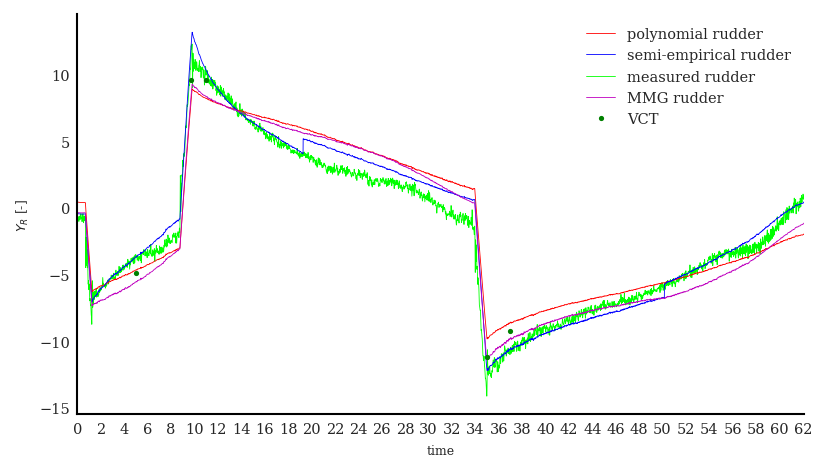

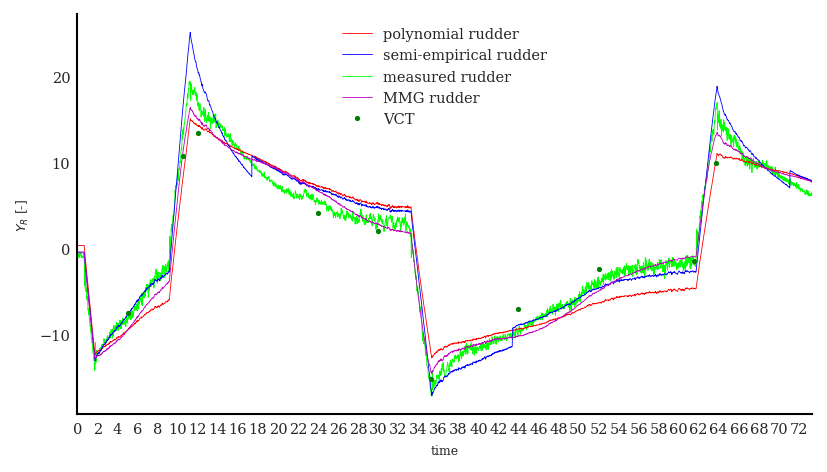

In [1010]:
t_maxs = {
    #23590 : 42, 
    #23594 : 65,
}
units_ = units.copy()
units_.pop('Y_R')
for id, meta_data in meta_datas.loc[[23590,23594]].iterrows():
#for id, meta_data in meta_datas.loc[[23594]].iterrows():
#for id, meta_data in meta_datas.iterrows():   
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    keys=['Y_R']
    fig = plot_compare_model_forces(model=model, models=models, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units_, 
                                    symbols=symbols, do_track_plot=False);
    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes,keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='VCT', zorder=100)

[11/28/24 10:26:33] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=921544;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=806334;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=815454;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=809752;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

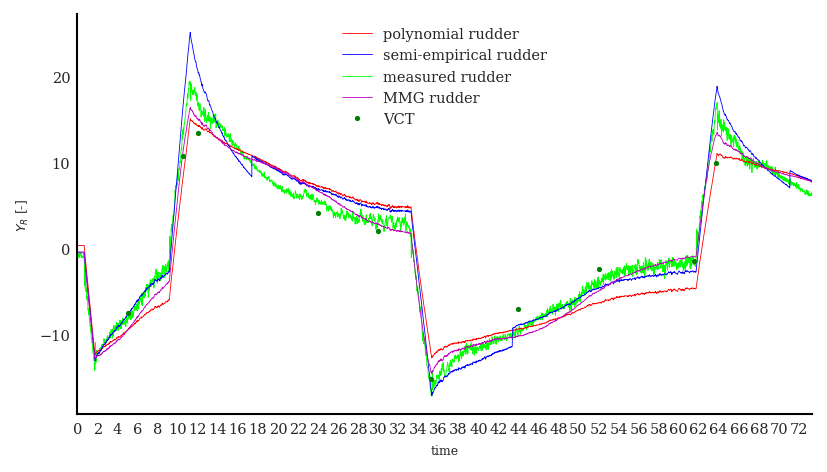

In [1011]:
units_ = units.copy()
units_.pop('Y_R')
#for id, meta_data in meta_datas.loc[[23590,23594]].iterrows():
for id, meta_data in meta_datas.loc[[23594]].iterrows():
#for id, meta_data in meta_datas.iterrows():   
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    keys=['Y_R']
    fig = plot_compare_model_forces(model=model, models=models, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units_, 
                                    symbols=symbols, do_track_plot=False);
    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes,keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='VCT', zorder=100)

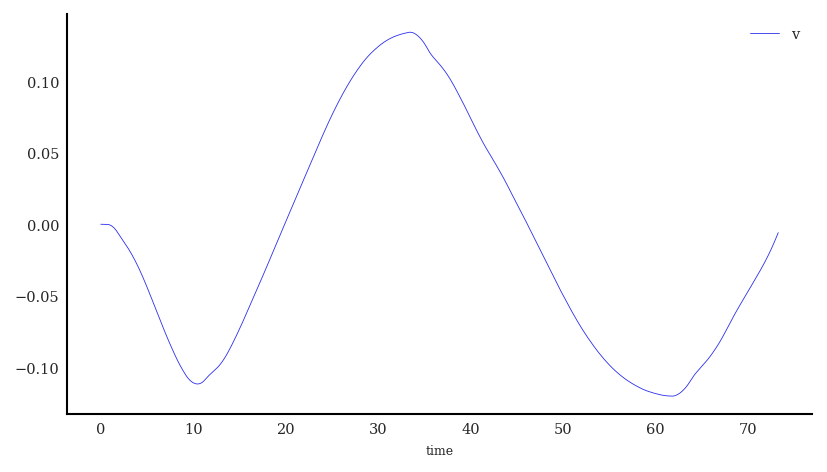

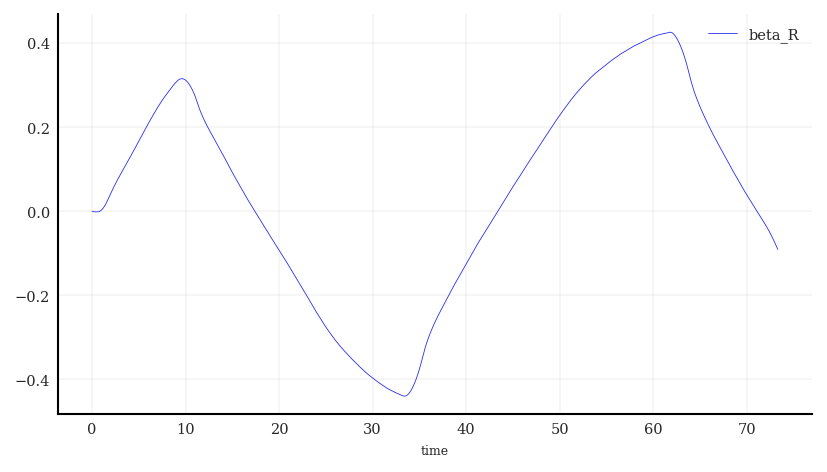

In [1012]:
df_ = predict(model_, data=df_EKF_smooth)
df_.plot(y='v')
fig,ax=plt.subplots()
df_.plot(y='beta_R',ax=ax)
ax.grid()
#df_.plot(y='gamma_g')

In [1013]:
data = df_EKF_smooth
forces_from_motions = model.forces_from_motions(data=data)
force_predictions = {name:predict(model=model, data=data) for name, model in models.items()}

In [1014]:
keys = ['Y_D','N_D']
_ = []
for name, df_prediction in force_predictions.items():
    score = pd.Series(name=name)
    for key in keys:
        score[key] = np.sqrt(r2_score(y_true=forces_from_motions[key], y_pred=df_prediction[key]))

    _.append(score)

scores = pd.DataFrame(_)


In [1015]:
scores

,Y_D,N_D
polynomial rudder simple,0.989984,0.983687
semiempirical rudder,0.979180,0.991397
measured rudder,0.982243,0.993291
MMG_rudder,0.984172,0.994735


(0.9591803963590902, 1.0)

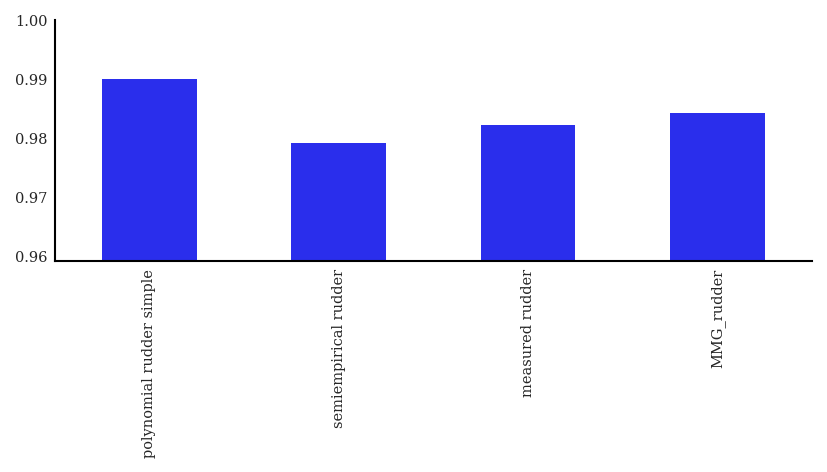

In [1016]:
fig,ax=plt.subplots()
scores['Y_D'].plot.bar(ax=ax)
ax.set_ylim(scores['Y_D'].min()-0.02,1)


(0.9591803963590902, 1.0)

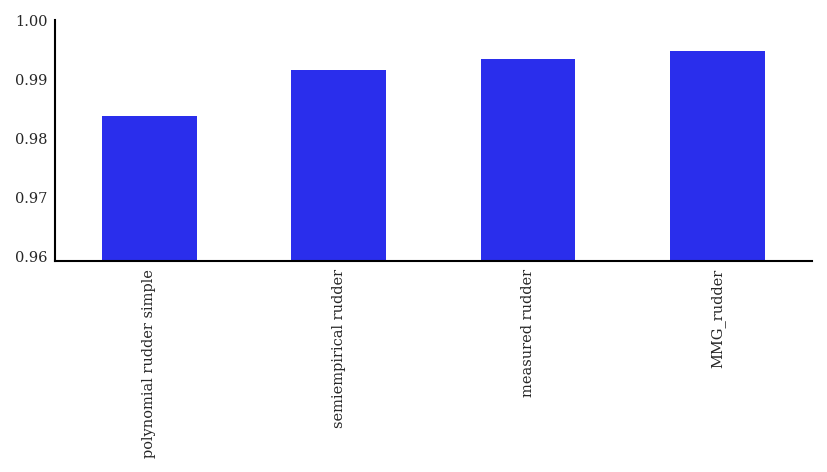

In [1017]:
fig,ax=plt.subplots()
scores['N_D'].plot.bar(ax=ax)
ax.set_ylim(scores['Y_D'].min()-0.02,1)

(0.9638950017875029, 1.0)

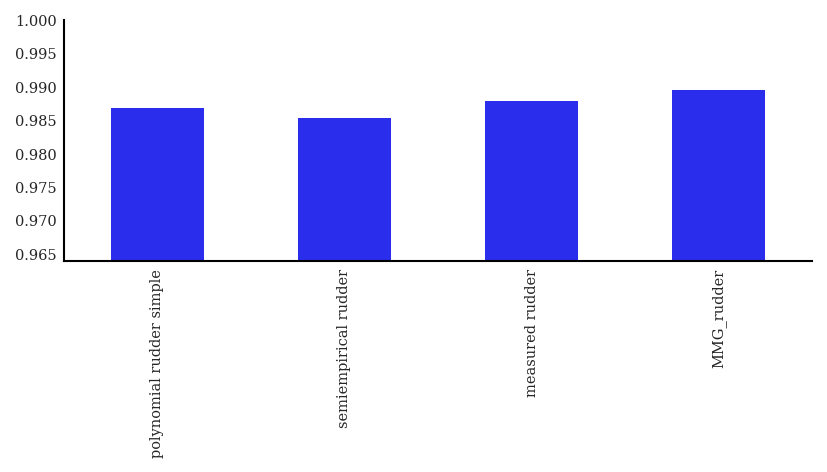

In [1018]:
fig,ax=plt.subplots()
scores.mean(axis=1).plot.bar()
ax.set_ylim(scores.mean().min().min()-0.02,1)


## Closed loop simulation

[11/28/24 10:26:36] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=775697;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=99925;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=953133;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=804899;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/28/24 10:26:40] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=984837;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=368963;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=937966;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=483490;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/28/24 10:26:43] WARNING  No artists with labels found to put in legend.  Note that artists whose ]8;id=121168;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=662941;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py#1363\1363]8;;\
                             label start with an underscore are ignored when legend() is called with               
                             no argument.                                                                          

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=265924;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=909397;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=354603;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=965474;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/28/24 10:26:46] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=894091;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=172970;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=934134;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=515682;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[11/28/24 10:26:49] WARNING  No artists with labels found to put in legend.  Note that artists whose ]8;id=426204;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=665825;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py#1363\1363]8;;\
                             label start with an underscore are ignored when legend() is called with               
                             no argument.                                                                          

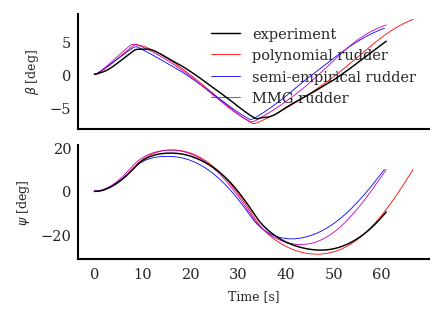

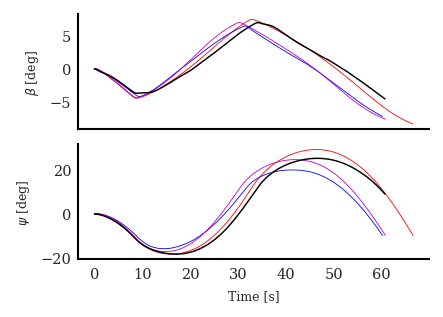

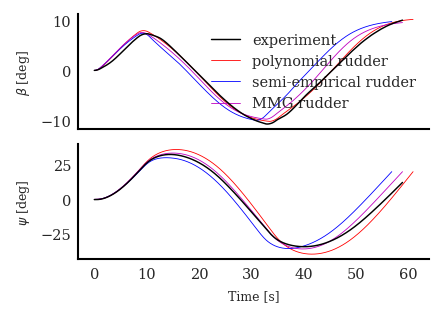

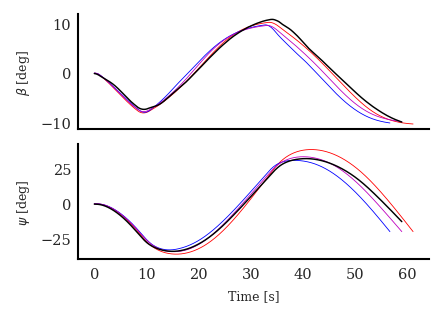

In [1019]:
simulations = {}

for angle, group in meta_datas.groupby(by='angle1'):

    #fig,ax=plt.subplots()
    include_label=True
    
    for id, meta_data in group.iterrows():
    
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
        df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
        df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    
        df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
        df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
        df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    
        dataframes = {'Experiment':df_EKF_smooth}
        
        for model_name, model in models.items():

            data = preprocess(df_EKF_smooth,ship_data=model.ship_parameters)
            angle = zigzag_angle(data_MDL=data)
        
            if model_name == "measured rudder":
                #df_simulation = model.simulate(data)
                continue
            else:
                df_simulation = simulate_closed_loop(model=model,data=data)

            if not id in simulations:
                simulations[id] = {}

            simulations[id][model_name] = df_simulation
            
            direction = "port" if angle > 0 else "stbd"
            name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction} {model_name}"
        
            dataframes[model_name] = df_simulation

        dataframes['Experiment'] = dataframes['Experiment'].loc[-1:df_simulation.index[-1]].copy()
        
        #track_plots(dataframes, lpp=model.ship_parameters['L'], beam=model.ship_parameters['B'], include_wind=False, styles=styles, ax=ax, include_label=include_label);
        #fig = ax.get_figure()
        
        direction = "port" if angle > 0 else "stbd"
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
        #fig.suptitle(name)
        #file_name = name.replace("/","_")
        #paper.save_fig(fig, f"track plot {file_name}.svg")
        
        fig = plot(dataframes, keys=['psi','beta'], units=units, styles=styles, ncols=1, include_label=include_label, symbols=symbols);
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
        for ax in fig.axes:
            ax.grid(False)

        fig.set_size_inches(paper.figure_width/2,paper.figure_height*2/3)
        
        #fig.suptitle(name)
        file_name = name.replace("/","_")
        paper.save_fig(fig, f"closed loop {file_name}.svg")
        
        
        include_label=False

In [1020]:
mask = pd.notnull(meta_datas_all['angle'])
meta_datas_all = meta_datas_all.loc[mask].copy()

meta_datas_all[['angle','comment']]

,angle,comment
23590,-10.0,ZZ10/10 SB
23591,10.0,ZZ10/10 SB
23592,-10.0,ZZ10/10 SB
23593,10.0,ZZ10/10 PS
23594,-20.0,ZZ20/20 SB
23595,-20.0,ZZ20/20 SB
23596,20.0,ZZ20/20 PS
23597,20.0,ZZ20/20 PS
23679,-10.0,ZZ10/10 SB
23680,10.0,ZZ10/10 PS


In [1021]:
IMO_evaluation.measure_overshoots(df_simulation)


15.33    14.391439
40.09    13.870167
Name: psi, dtype: float64

In [1022]:
IMO_evaluation.measure_overshoots(df_EKF_smooth)


time
14.979986    14.046294
40.589996    12.413888
67.979999    12.360698
Name: psi, dtype: float64

In [1023]:
def pack_overshoots(overshoots):
    overshoot_result = {}
    for n,(time, overshoot) in enumerate(overshoots.items()):  
        overshoot_result[f'overshoot_{n+1}'] = overshoot
        overshoot_result[f't_{n+1}'] = time

    return overshoot_result

In [1024]:
_ = []
for id, meta_data in meta_datas_all.iterrows():
    
    try:
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    except:
        continue
    #df_EKF_smooth = catalog.load(f"{ship_name}.tests")[str(id)]()
    
    overshoots = IMO_evaluation.measure_overshoots(df_EKF_smooth, angle=meta_data['angle'])
    overshoot_result = pack_overshoots(overshoots)
    overshoot_result = pd.Series(overshoot_result, name=id)
    overshoot_result['angle'] = meta_data['angle']
    
    
    _.append(overshoot_result)
    
overshoot_results = pd.DataFrame(_)

[11/28/24 10:26:50] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=404159;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=549568;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=144830;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=630131;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=741826;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=420450;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=906001;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=43257;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=78932;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=44065;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=708229;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=321474;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=821496;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=807523;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=379400;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=503268;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=54583;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=636247;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=332073;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=272736;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=287713;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=686584;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=205624;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=571501;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [1025]:
overshoot_results.sort_values(by='angle')

,overshoot_1,t_1,overshoot_2,t_2,angle,overshoot_3,t_3
23594,12.275516,15.180002,13.988310,40.799998,-20.0,10.929683,68.279999
23595,12.687193,15.399989,14.028674,41.460002,-20.0,10.805342,68.809988
23682,12.451062,15.340005,13.836021,41.039996,-20.0,11.003151,68.630016
23590,7.432821,16.550008,17.138650,47.909988,-10.0,NaN,NaN
23592,7.625012,17.079992,17.168450,47.769985,-10.0,NaN,NaN
23679,7.886254,17.329988,17.687529,49.059983,-10.0,NaN,NaN
23591,8.464648,17.709999,15.291949,47.250018,10.0,NaN,NaN
23593,8.537342,17.669989,15.042208,47.099989,10.0,NaN,NaN
23680,8.724413,17.660002,14.986429,47.369995,10.0,NaN,NaN
23596,14.046294,15.659982,12.413888,41.269992,20.0,12.360698,68.659995


In [1026]:
meta_data['angle']

-20.0

In [1027]:
overshoot_results['id'] = overshoot_results.index

<Axes: xlabel='id'>

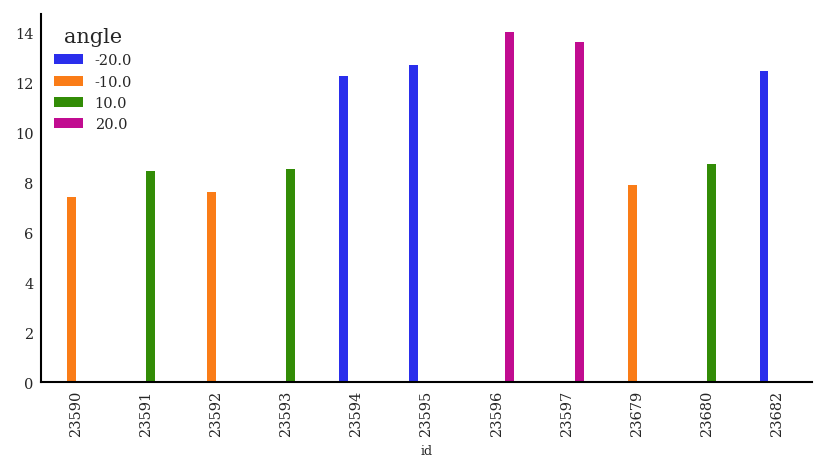

In [1028]:
overshoot_results.pivot(index='angle', columns='id', values='overshoot_1').transpose().plot.bar()

<Axes: xlabel='angle'>

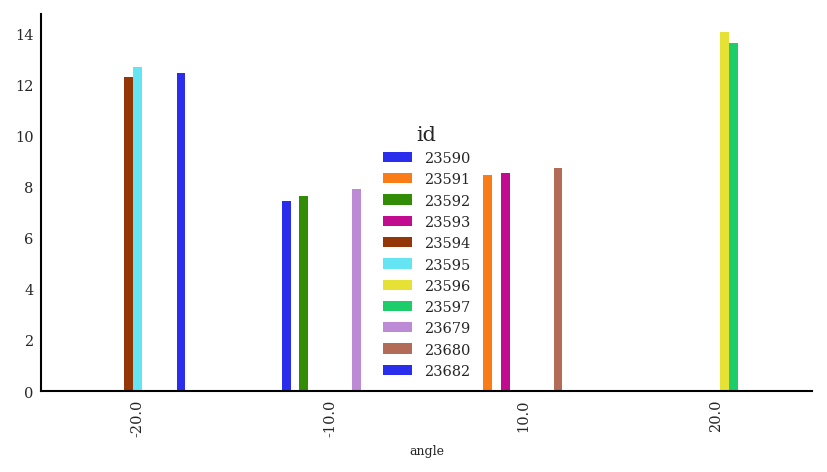

In [1029]:
overshoot_results.pivot(index='angle', columns='id', values='overshoot_1').plot.bar()

In [1030]:
overshoot_experiment_mean = overshoot_results.groupby(by='angle').mean()
overshoot_experiment_mean['model_name'] = 'Experiment'
overshoot_experiment_mean['angle'] = overshoot_experiment_mean.index

In [1031]:
overshoot_results.groupby(by='angle').std()

,overshoot_1,t_1,overshoot_2,t_2,overshoot_3,t_3,id
angle,,,,,,,
-20.0,0.206580,0.113720,0.101601,0.334068,0.099988,0.269503,50.520623
-10.0,0.227591,0.398278,0.308653,0.707835,NaN,NaN,50.816664
10.0,0.134014,0.026458,0.162699,0.135281,NaN,NaN,50.816664
20.0,0.302530,0.070699,0.168781,0.127267,0.155845,0.028285,0.707107


In [1032]:
_ = []
for id, model_simulations in simulations.items():

    meta_data = meta_datas_all.loc[id]
    
    for model_name, df_simulation in model_simulations.items():
        
        overshoots = IMO_evaluation.measure_overshoots(df_simulation, angle=meta_data['angle'])
        overshoot_result = pack_overshoots(overshoots)
        overshoot_result['id'] = id
        overshoot_result['model_name'] = model_name
        overshoot_result['angle'] = meta_data['angle']
        _.append(overshoot_result)
    
overshoot_simulation_results = pd.DataFrame(_)
overshoot_simulation_results = pd.concat((overshoot_simulation_results,overshoot_experiment_mean,))

In [1033]:
overshoot_simulation_results['angle'] = overshoot_simulation_results['angle'].astype(int)

In [1034]:
overshoot_simulation_results

,overshoot_1,t_1,overshoot_2,t_2,id,model_name,angle,overshoot_3,t_3
0.0,8.963840,16.290000,19.081040,46.490000,23590.000000,polynomial rudder simple,-10,NaN,NaN
1.0,6.020038,15.110000,12.052578,41.220000,23590.000000,semiempirical rudder,-10,NaN,NaN
2.0,8.893148,15.850000,14.635336,43.060000,23590.000000,MMG_rudder,-10,NaN,NaN
3.0,8.563846,16.090000,19.422494,46.360000,23591.000000,polynomial rudder simple,10,NaN,NaN
4.0,6.086832,14.550000,10.059210,41.320000,23591.000000,semiempirical rudder,10,NaN,NaN
5.0,7.391986,14.880000,14.776144,41.910000,23591.000000,MMG_rudder,10,NaN,NaN
6.0,15.946912,15.680000,19.448597,41.610000,23594.000000,polynomial rudder simple,-20,NaN,NaN
7.0,10.031975,13.730000,15.430119,37.170000,23594.000000,semiempirical rudder,-20,NaN,NaN
8.0,13.378582,15.020000,15.721255,39.890000,23594.000000,MMG_rudder,-20,NaN,NaN
9.0,16.163503,15.720000,19.035483,41.630000,23596.000000,polynomial rudder simple,20,NaN,NaN


In [1035]:
styles


{
    'VCT': {'style': 'k.', 'zorder': 100, 'lw': 0.7, 'label': 'VCT'},
    'Experiment': {'style': 'k-', 'zorder': 100, 'lw': 0.7, 'label': 'experiment'},
    'polynomial rudder': {'style': '-', 'color': 'red', 'label': 'polynomial rudder'},
    'semiempirical rudder': {'style': '-', 'color': '#0000ff', 'label': 'semi-empirical rudder'},
    'measured rudder': {
        'style': '-',
        'color': '#00ff00',
        'zorder': -100,
        'alpha': 1,
        'label': 'measured rudder'
    },
    'MMG_rudder': {'style': 'm-', 'label': 'MMG rudder'},
    'polynomial rudder simple': {'style': '-', 'color': 'red', 'label': 'polynomial rudder'},
    'polynomial rudder complex': {'style': 'm-', 'label': 'complex'}
}

In [1036]:
def get_name(row):
    angle = row.name
    direction = "port" if angle > 0 else "stbd"
    name = f"{abs(angle):0.0f}/{abs(angle):0.0f} {direction}"
    return name

In [1037]:
def get_colors(overshoot_simulation_results_pivot):
    colors = []
    for name in overshoot_simulation_results_pivot.columns:
        if name=='name':
            continue
    
        style= styles[name]
        color = style.get('color',style['style'][0])
        colors.append(color)
    return colors

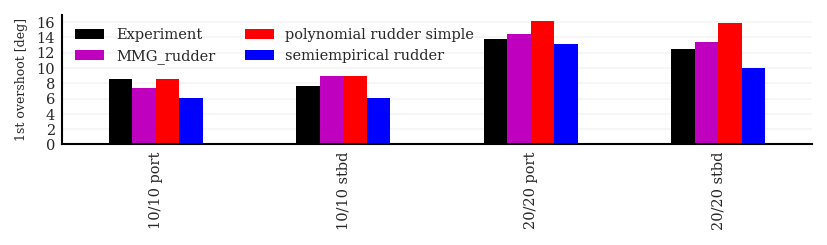

In [1038]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_1')
colors = get_colors(overshoot_simulation_results_pivot)

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(get_name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=colors, ax=ax)
ax.legend(ncols=2)
ax.set_xlabel('')
ax.set_ylabel('1st overshoot [deg]')

loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot1.svg")

In [1039]:
df_overshoot_diff = overshoot_simulation_results_pivot.select_dtypes(exclude='object').sub(overshoot_simulation_results_pivot['Experiment'],axis=0)
df_overshoot_diff.abs().mean(numeric_only=True)


model_name
Experiment                  0.000000
MMG_rudder                  0.973748
polynomial rudder simple    1.783554
semiempirical rudder        1.823113
dtype: float64

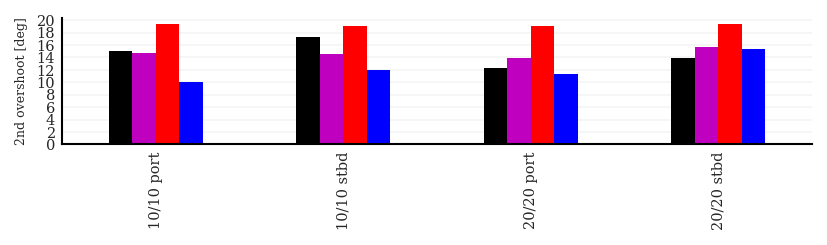

In [1040]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_2')

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(get_name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=colors, ax=ax)

#ax.legend(ncols=3)
ax.get_legend().set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('2nd overshoot [deg]')

loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot2.svg")

In [1041]:
overshoot_simulation_results_pivot

model_name,Experiment,MMG_rudder,polynomial rudder simple,semiempirical rudder,name
angle,,,,,
10,15.106862,14.776144,19.422494,10.059210,10/10 port
-10,17.331543,14.635336,19.081040,12.052578,10/10 stbd
20,12.294542,13.870167,19.035483,11.288161,20/20 port
-20,13.951002,15.721255,19.448597,15.430119,20/20 stbd


In [1042]:
df_overshoot_diff

model_name,Experiment,MMG_rudder,polynomial rudder simple,semiempirical rudder
angle,,,,
10,0.0,-1.183481,-0.011622,-2.488636
-10,0.0,1.245119,1.315811,-1.627990
20,0.0,0.559066,2.331131,-0.736545
-20,0.0,0.907325,3.475655,-2.439283


In [1043]:
df_overshoot_diff.abs().mean(axis=0)


model_name
Experiment                  0.000000
MMG_rudder                  0.973748
polynomial rudder simple    1.783554
semiempirical rudder        1.823113
dtype: float64

<Axes: >

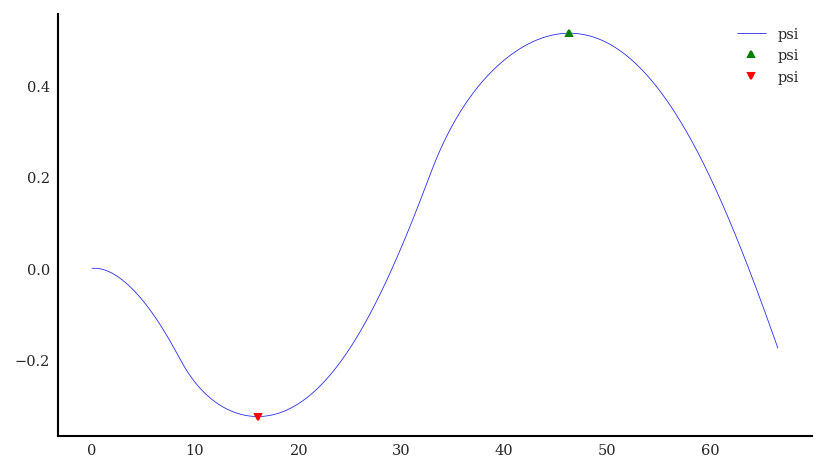

In [1044]:
df_simulation = simulations[23591]['polynomial rudder simple']

maximums = IMO_evaluation.maximums(df_simulation)
minimums = IMO_evaluation.minimums(df_simulation)

fig,ax=plt.subplots()
df_simulation.plot(y='psi',ax=ax)
maximums.plot(y='psi', style='g^', ax=ax)
minimums.plot(y='psi', style='rv', ax=ax)

[11/28/24 10:26:52] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=248217;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=71402;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

<Axes: xlabel='time'>

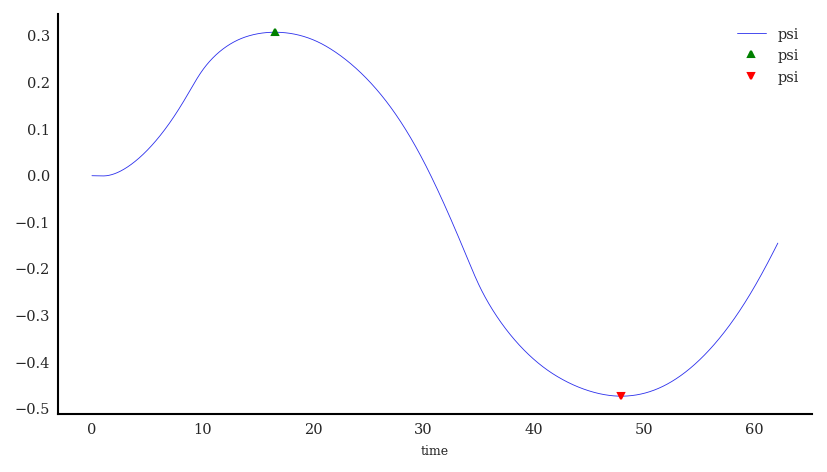

In [1045]:
id = 23590
df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()

maximums = IMO_evaluation.maximums(df_EKF_smooth, angle=10)
minimums = IMO_evaluation.minimums(df_EKF_smooth, angle=10)

fig,ax=plt.subplots()
df_EKF_smooth.plot(y='psi',ax=ax)
maximums.plot(y='psi', style='g^', ax=ax)
minimums.plot(y='psi', style='rv', ax=ax)

In [1046]:
meta_datas_all.loc[23590]['angle']

-10.0

In [1047]:
IMO_evaluation.measure_overshoots(df_EKF_smooth, angle=10)


time
16.550008     7.432821
47.909988    17.138650
Name: psi, dtype: float64

<Axes: xlabel='time'>

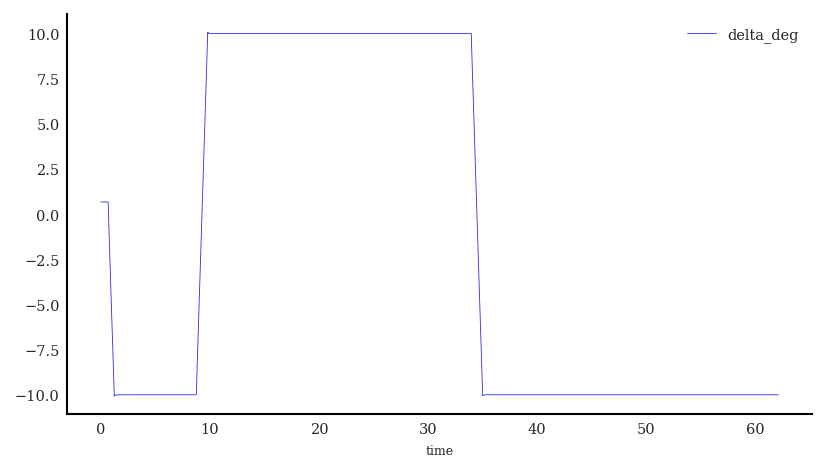

In [1048]:
df_EKF_smooth['delta_deg'] = np.rad2deg(df_EKF_smooth['delta'])
df_EKF_smooth.plot(y='delta_deg')